In [1]:
cd ..

/home/dmitrii/arithmia_project/training_pipeline/JET_detection


In [2]:
import pandas as pd
import numpy as np
from biosppy.signals.ecg import christov_segmenter

import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import f1_score

from data_generator import Preprocessing
from utils.peak_finder import Peak_finder
from utils.confusion_matrix_pretty_print import plot_confusion_matrix_from_data
from utils.post_processing import PostProcessing

peak_finder = Peak_finder()
prep = Preprocessing(aug=False)
from models.resnet import Model

/home/dmitrii/arithmia_project/training_pipeline/JET_detection/models/resnet_pre_trained/model_config.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  hparams = yaml.load(open(f"{os.path.dirname(os.path.abspath(__file__))}/hparams.yml"))
/home/dmitrii/arithmia_project/training_pipeline/JET_detection/models/resnet/model_config.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  hparams = yaml.load(open(f"{os.path.dirname(os.path.abspath(__file__))}/hparams.yml"))


In [15]:
DEBUG_PATH = './data/CV_debug/'
DATA_PATH = './data/JET_data/processed_data/'

patients = [i for i in os.listdir(DEBUG_PATH) if i.find('.')==-1]

print(f'Total number of patients: {len(patients)}')

records = []

for patient in patients:
    
    record = [patient+'/'+i[:-4] for i in os.listdir(DATA_PATH+patient) if i.find('.npy')!=-1]
    
    records+=record
    
print(f'Total number of records {len(records)}')

postprocessing = PostProcessing()

Total number of patients: 11
Total number of records 3600


# Download the data

In [33]:
preds = []
error = []
labels = []
signals = []

for record in records:
    ann = json.load(open(DEBUG_PATH+record+'.json'))
    error.append(ann['error'])
    preds.append(ann['prediction'])
    labels.append(json.load(open(DATA_PATH+record+'.json'))['label'][0])
    signals.append(np.load(DATA_PATH+record+'.npy'))
                 
                 
error = np.array(error)
preds = np.array(preds)
labels = np.array(labels)
signals = np.array(signals)
records = np.array(records)

# KPI

## F1 total

In [34]:
preds_hard = postprocessing.run(preds)

print(f"F1 total: {f1_score(labels,preds_hard,labels=[0,1,2],average='macro')}")

F1 total: 0.7413330731457299


## F1 for each class

In [35]:
n_classes = 3

labels_oh = np.eye(n_classes)[labels]
preds_oh = np.eye(n_classes)[preds_hard]

for cl in range(n_classes):
    y_temp = labels_oh[:,cl]
    pred_temp = preds_oh[:,cl]
    
    print(f"Class: {cl}, F1 score: {f1_score(y_temp,pred_temp)}")

Class: 0, F1 score: 0.662431941923775
Class: 1, F1 score: 0.7380378657487092
Class: 2, F1 score: 0.8235294117647057


## Confustion Matrix

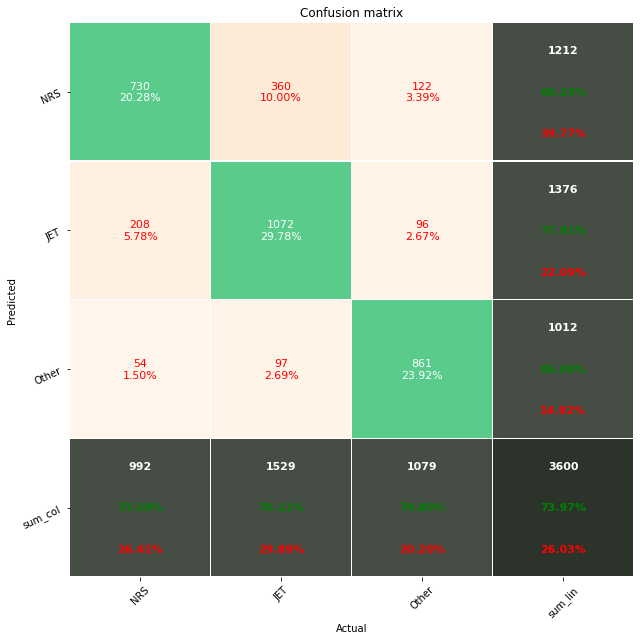

In [36]:
plot_confusion_matrix_from_data(labels,preds_hard,columns=['NRS','JET','Other'])

# Qualitative examples

In [37]:
labels = np.eye(n_classes, dtype=np.float32)[labels.astype(np.int8)]


inds = error.argsort()
labels = labels[inds[::-1],:]
signals = signals[inds[::-1],:]
records = records[inds[::-1]]
preds = preds[inds[::-1]]

N = 10

#select top best
labels_best = labels[-N:,:].copy()
signals_best = signals[-N:,:]
records_best = records[-N:]
preds_best = preds[-N:]

#select top worst
labels_worst = labels[:N,:].copy()
signals_worst = signals[:N,:].copy()
records_worst = records[:N]
preds_worst = preds[:N]

## Plots

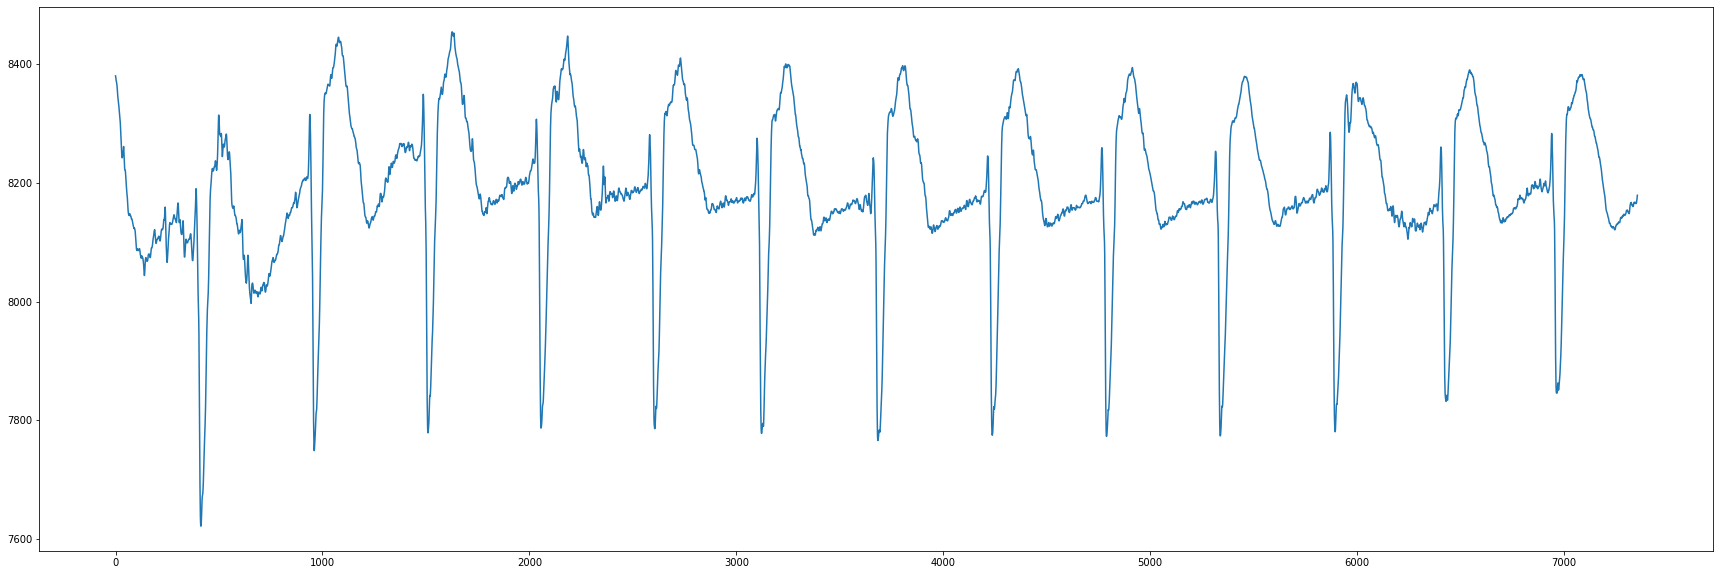

In [59]:
signal = np.load(DATA_PATH+'5025547/169'+'.npy')


fig = plt.figure(figsize=(30,10))
plt.plot(signal[7500+100+20+10+5+10:])
plt.show()



## Worst

5025542/485


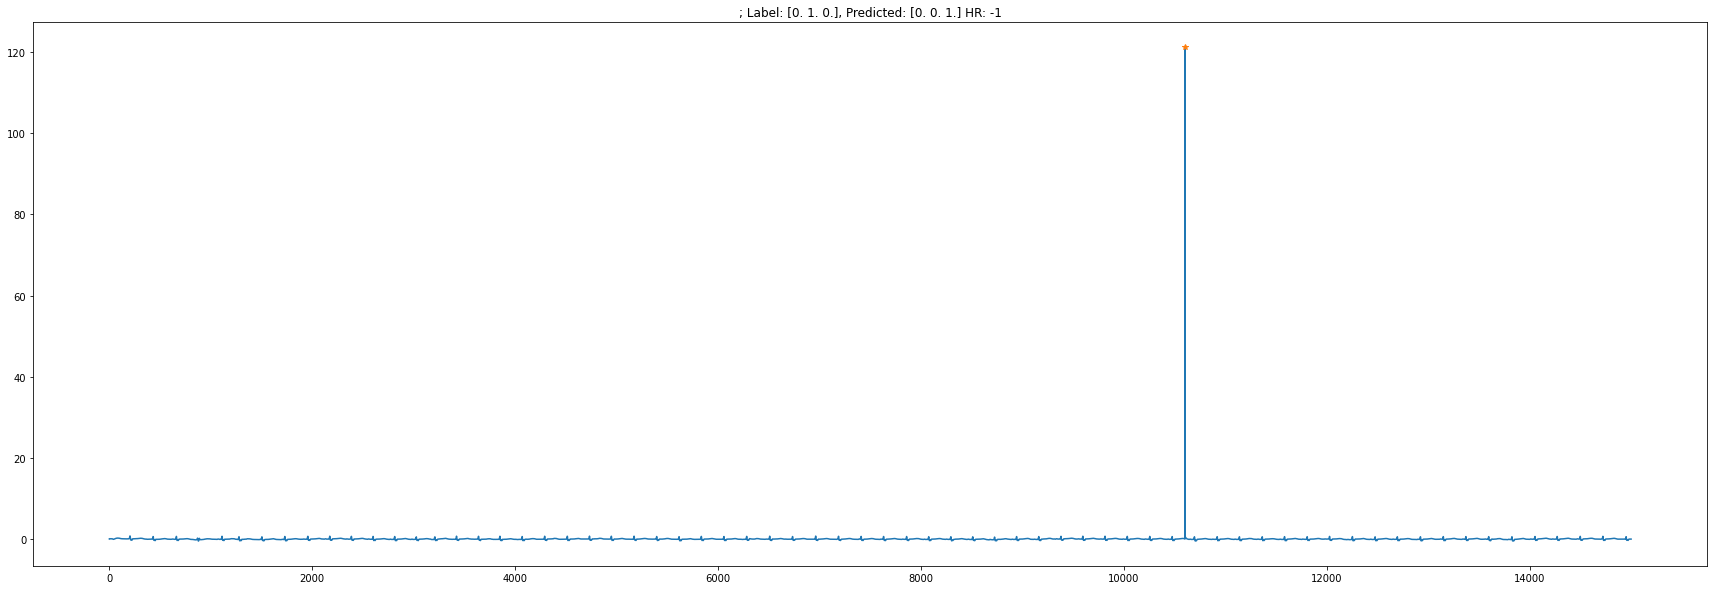

5025542/605


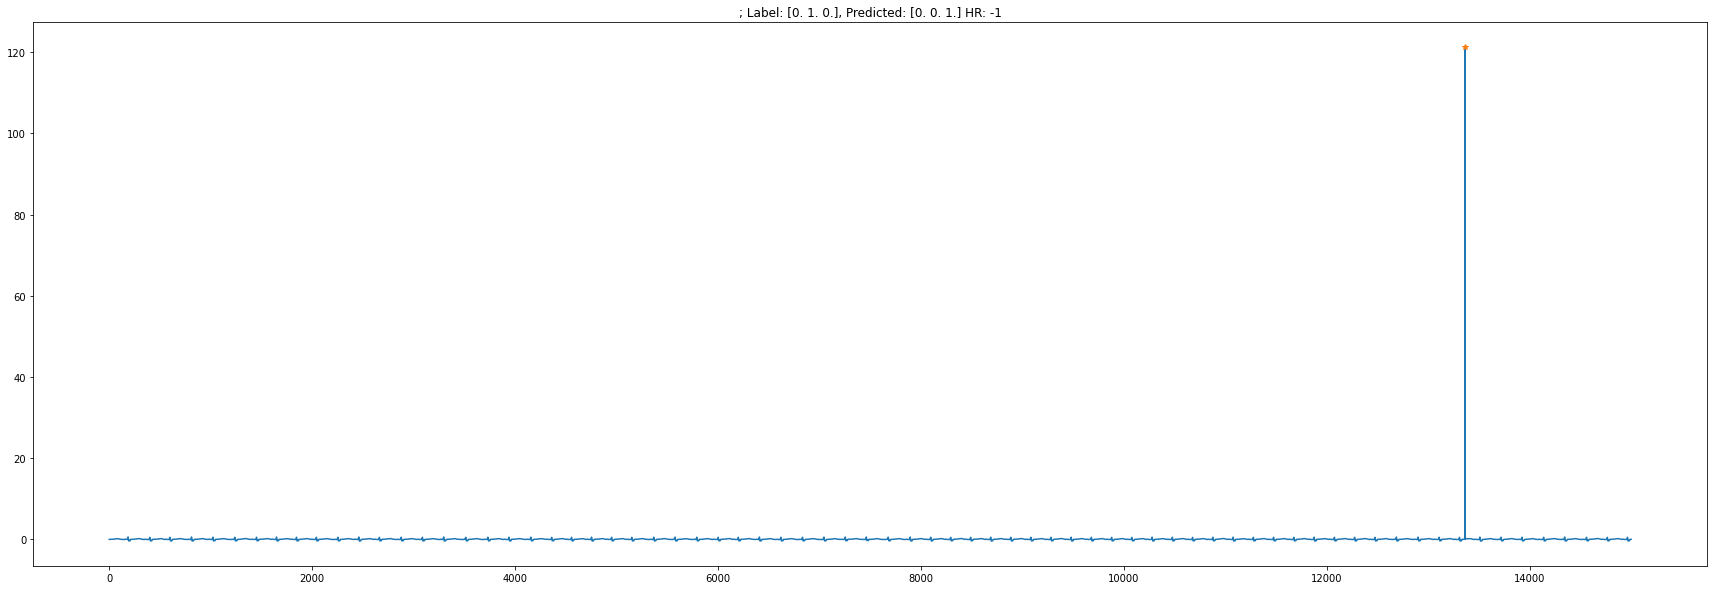

5025542/46


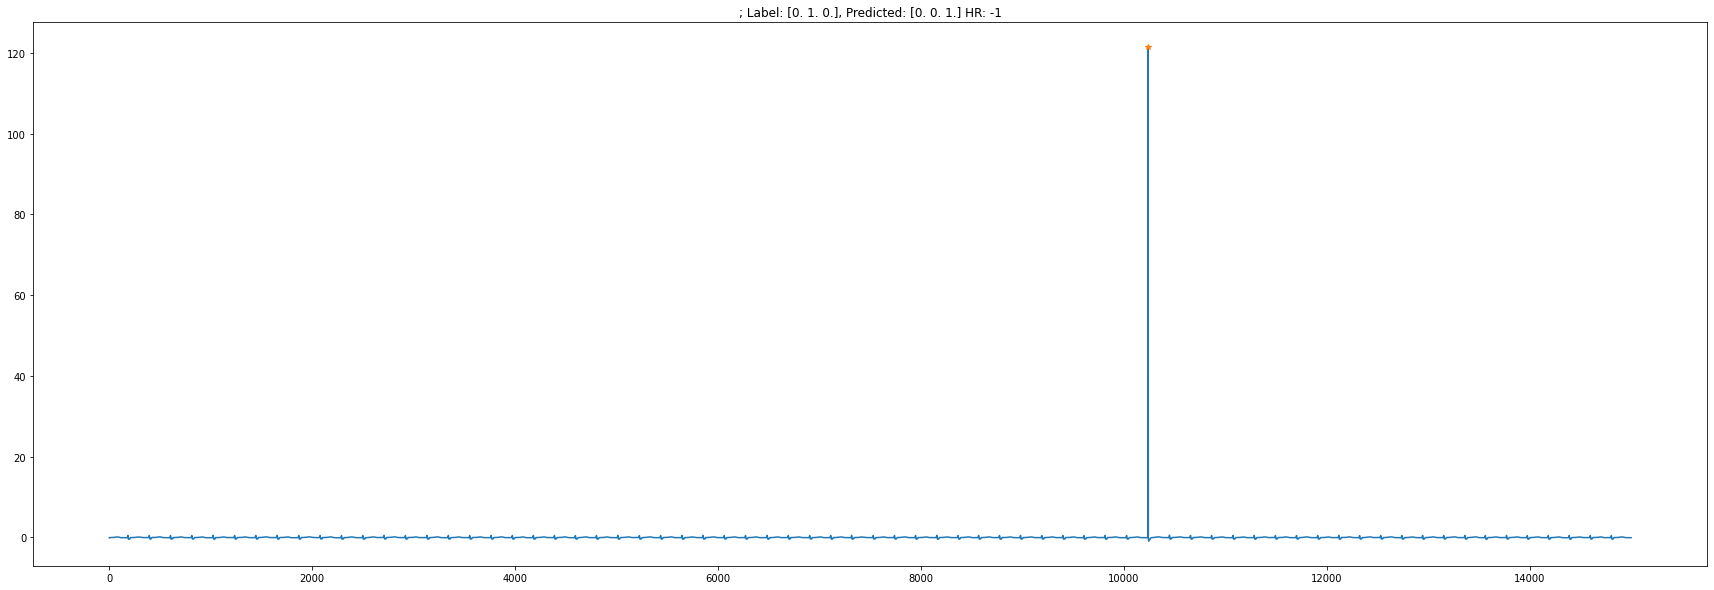

5025542/604


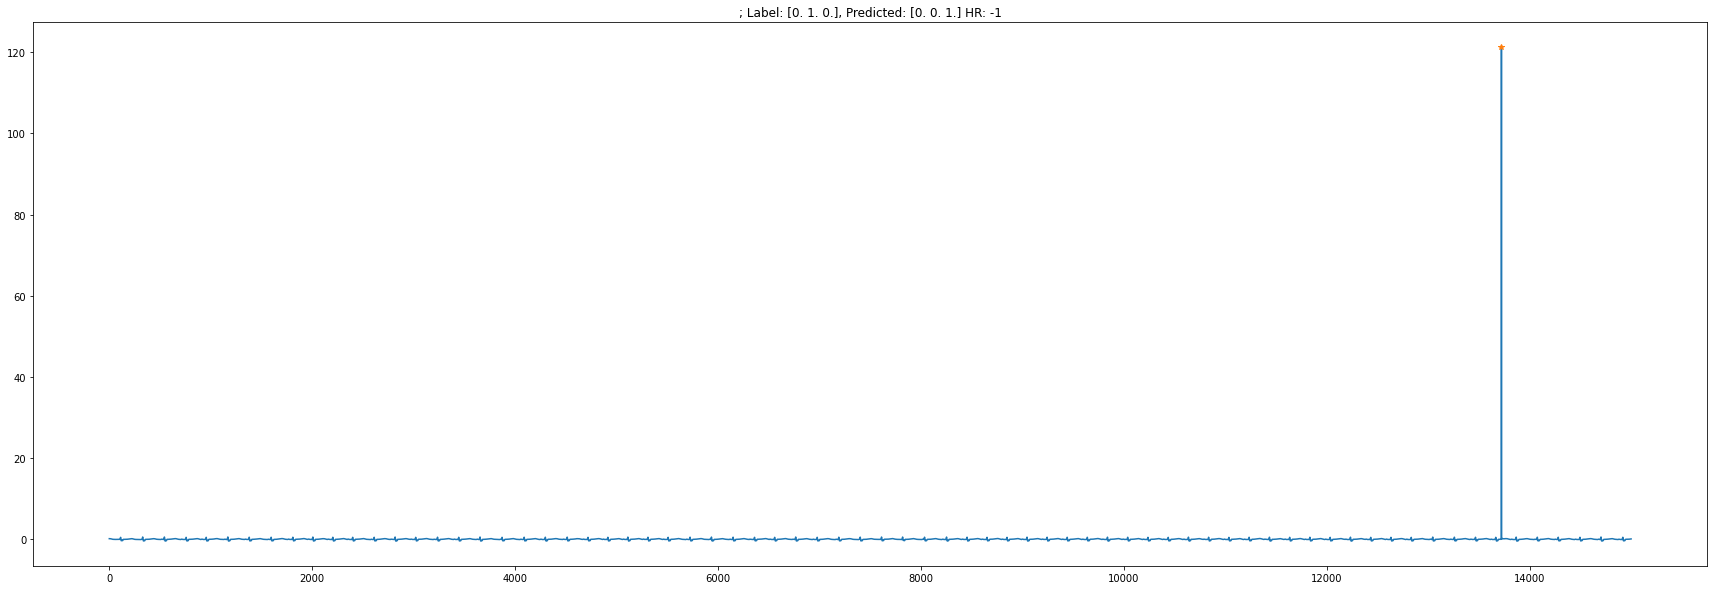

5025542/83


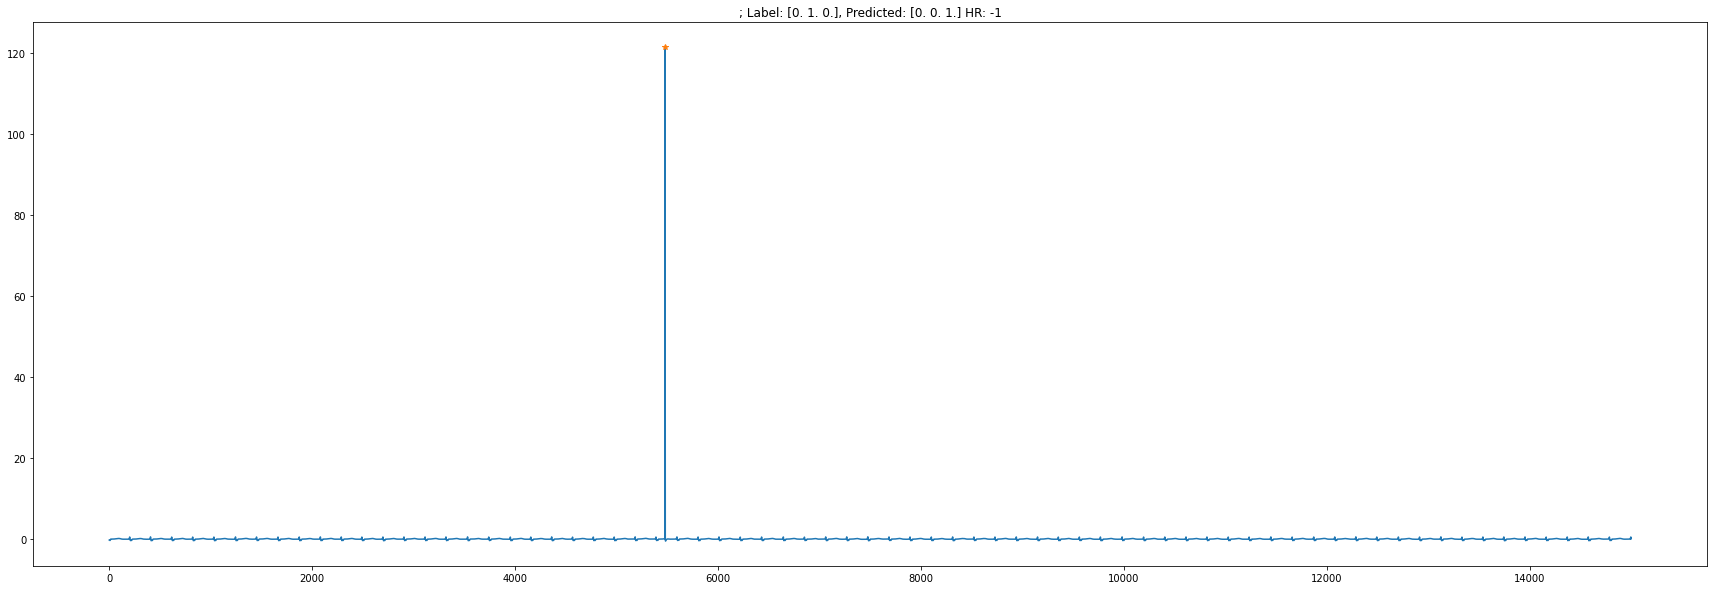

5025542/489


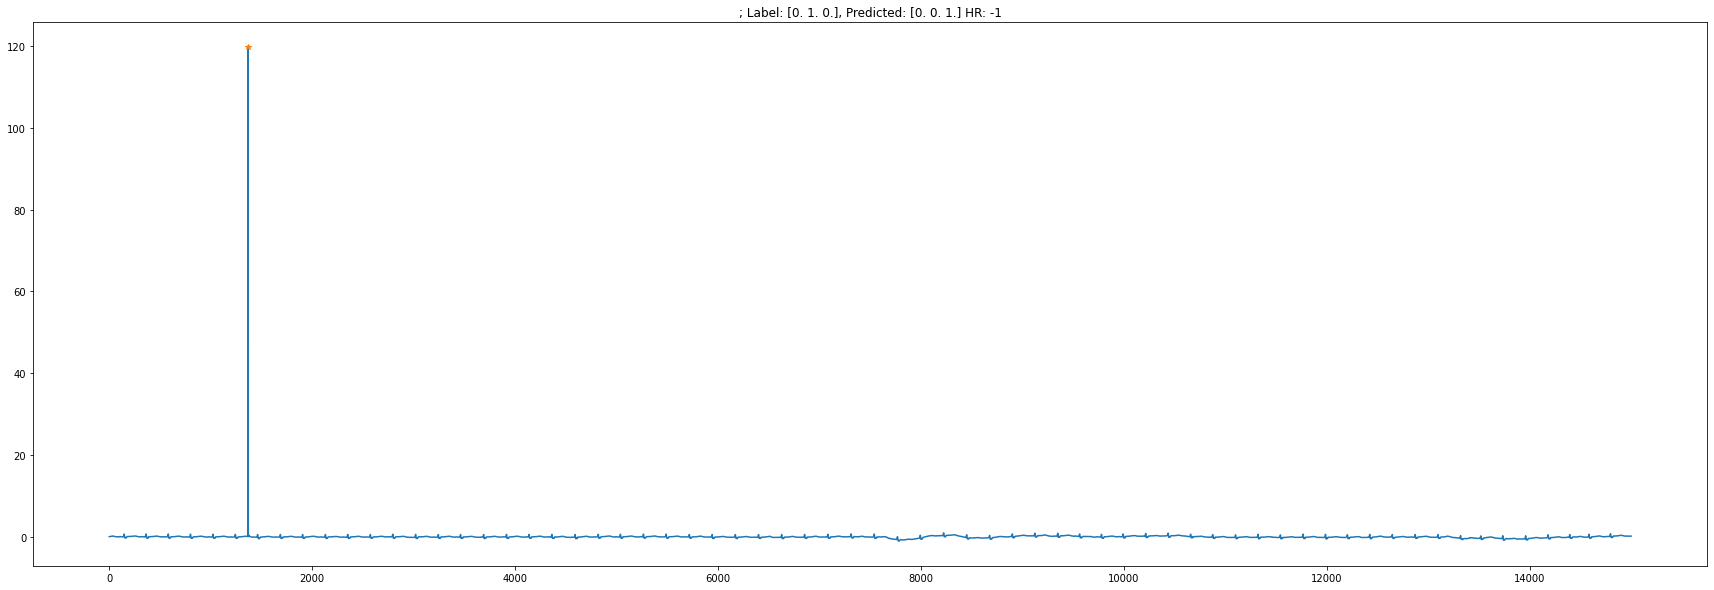

5025542/483


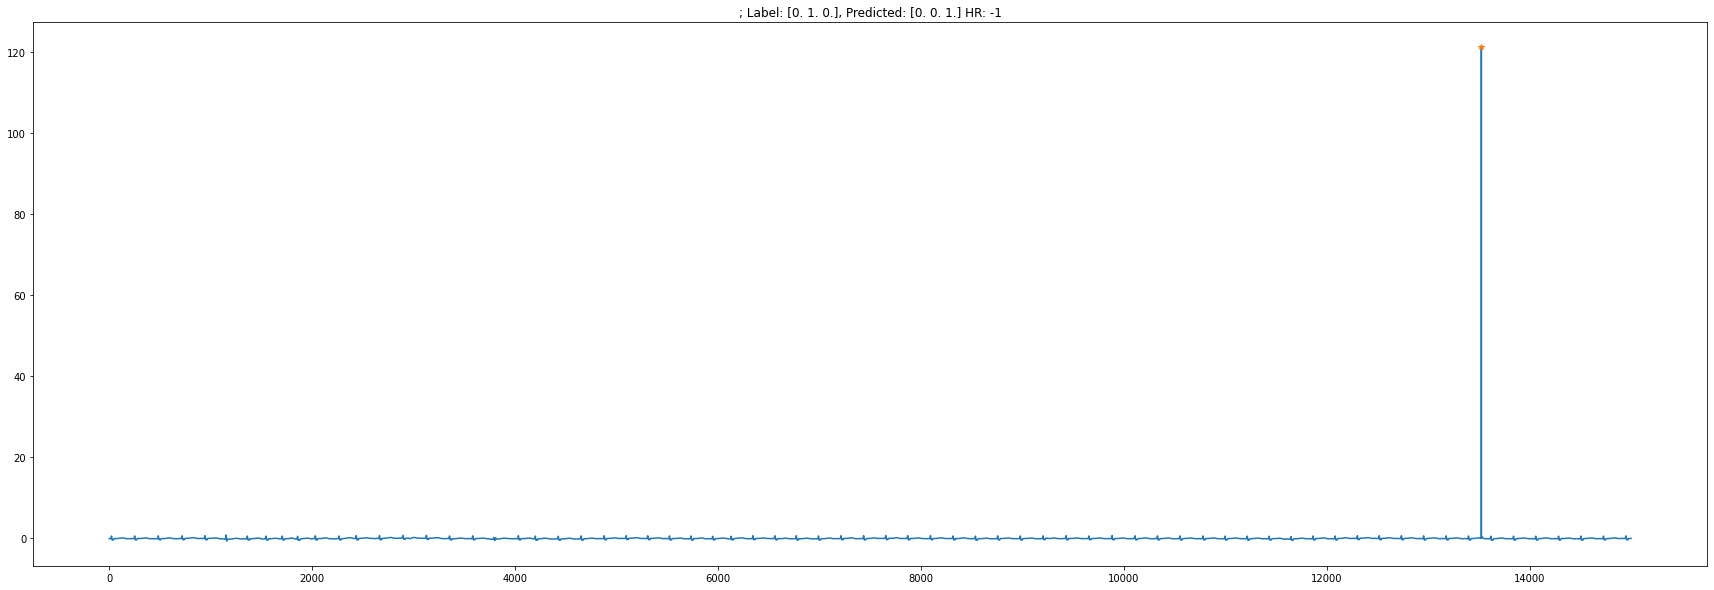

5025542/47


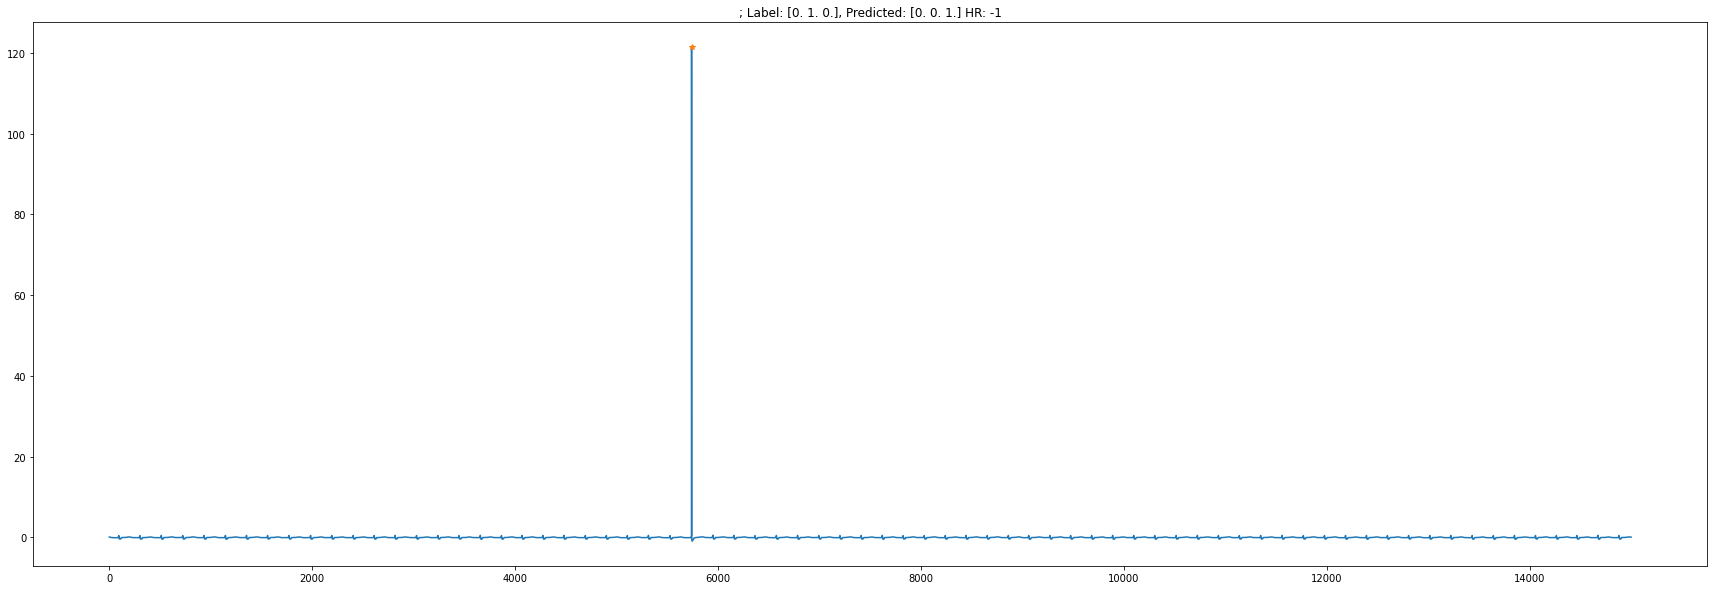

5025542/484


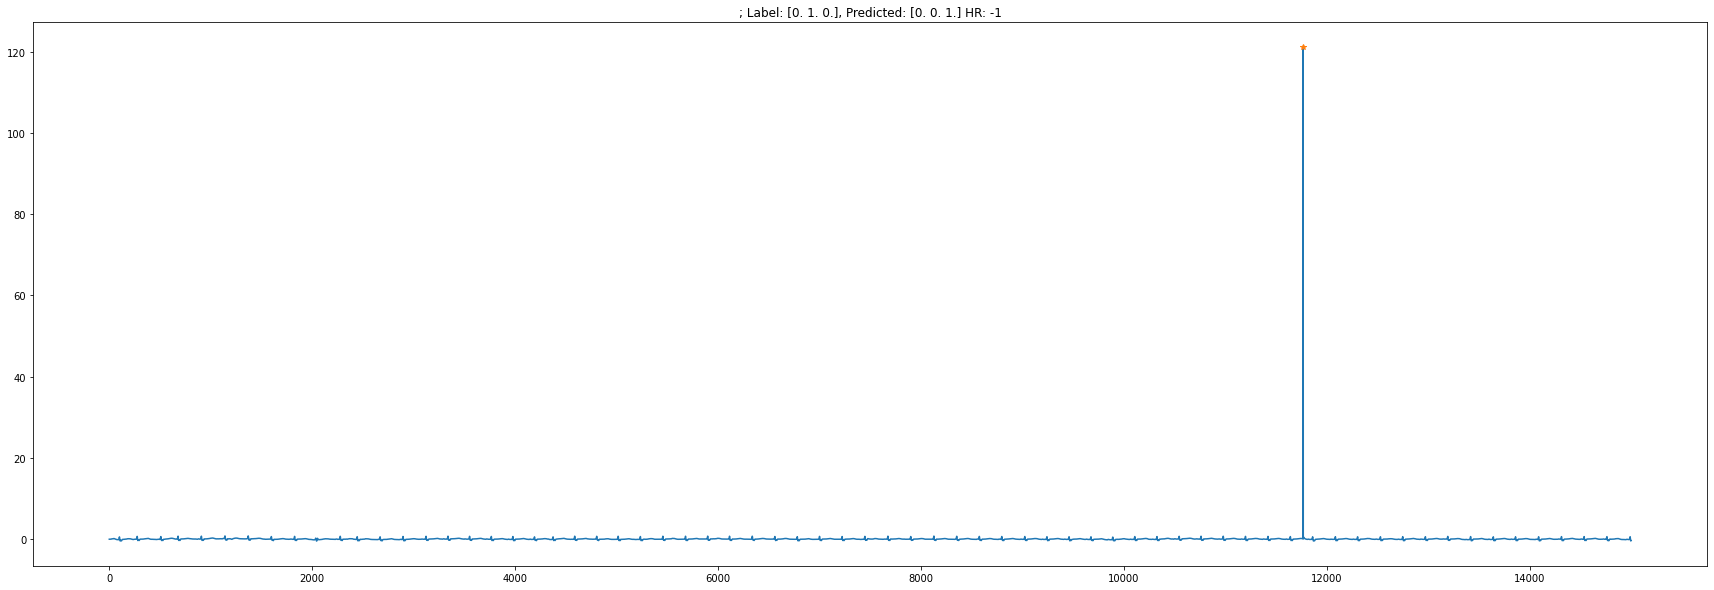

5025542/84


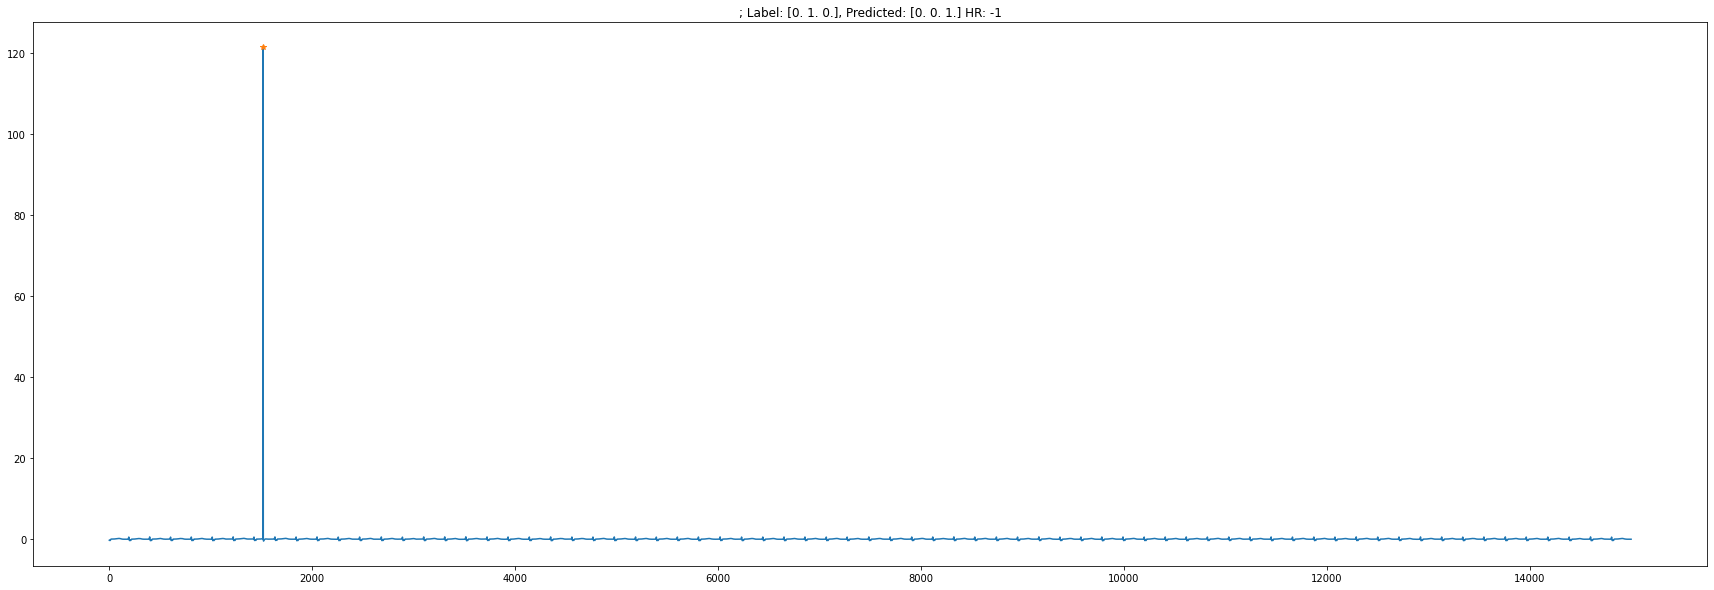

In [39]:
for i in range(N):
    
    #apply preprocessing
    signal = prep.run(signals_worst[i],np.array([1]),label_process=False)
    signal = signal.reshape(-1)
    
    #find heart rate
    rr = peak_finder.find_peaks_abp(signal, threshold=4)  #christov_segmenter(signal=signals_worst[i], sampling_rate=125)
    if rr.shape[0]>5:
        HR = np.median(np.diff(rr))
        HR = 60/(HR/500)
    else:
        HR = -1
    
    
    
    fig = plt.figure(figsize=(30,10))
    plt.plot(signal)
    plt.plot(rr,signal[rr],'*')
    plt.title(f'; Label: {labels_worst[i,:]}, Predicted: {np.round(preds_worst[i,:],2)} HR: {HR}')
    print(records_worst[i])
    plt.show()
    
    

## Best

5025547/102


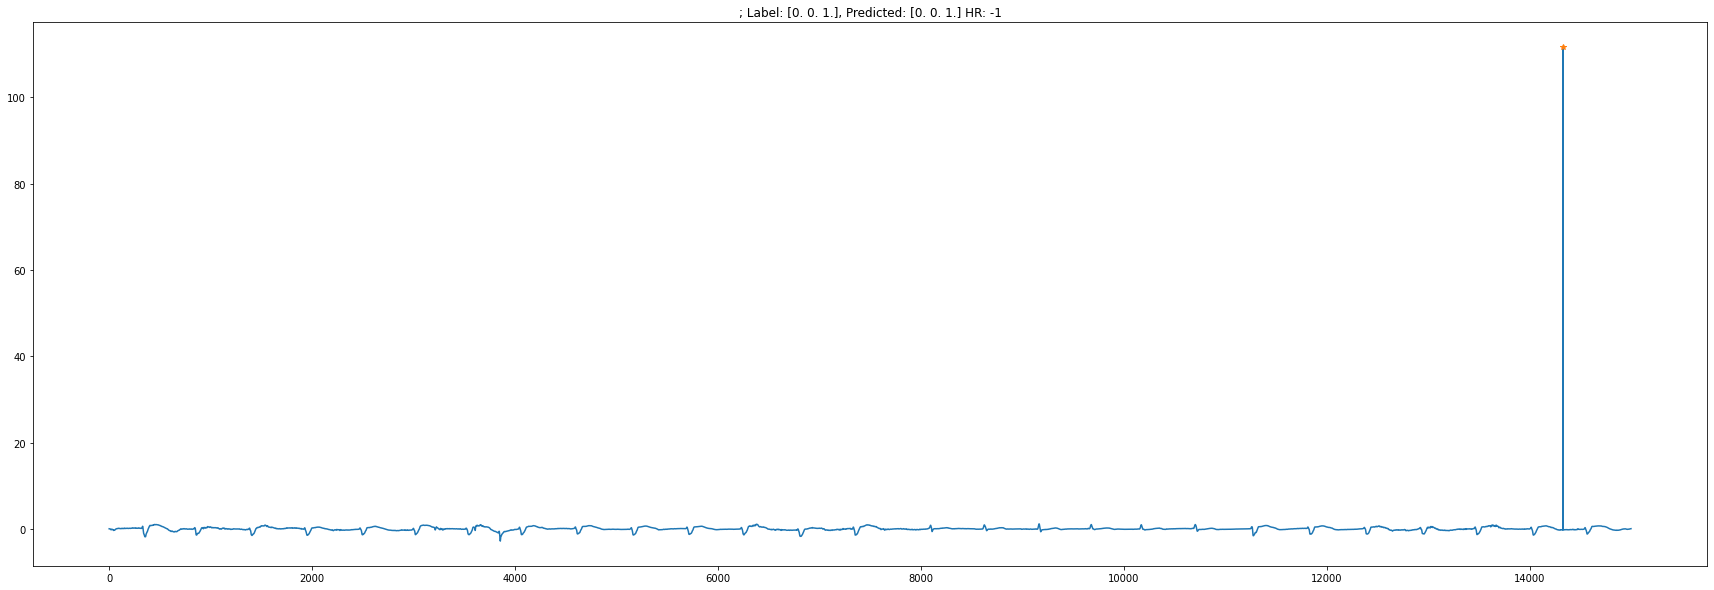

5025542/486


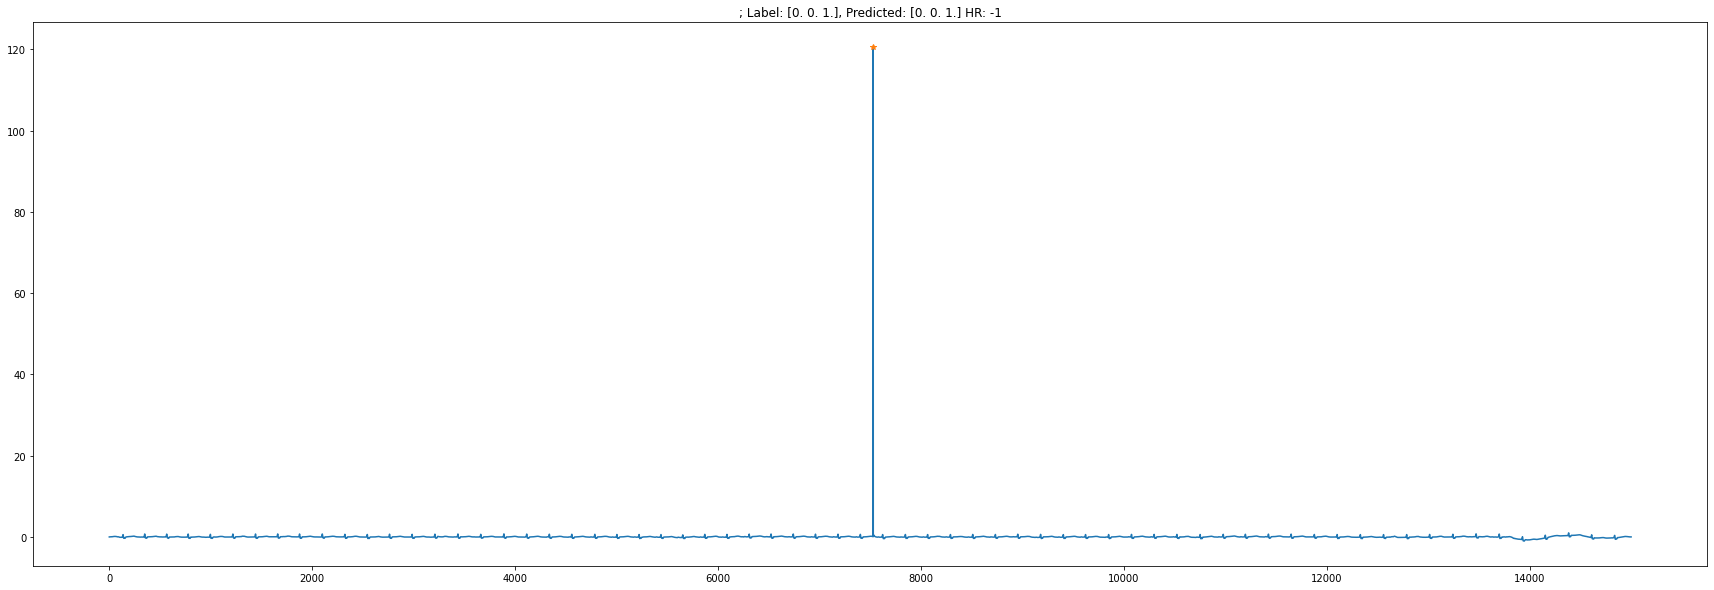

5025547/105


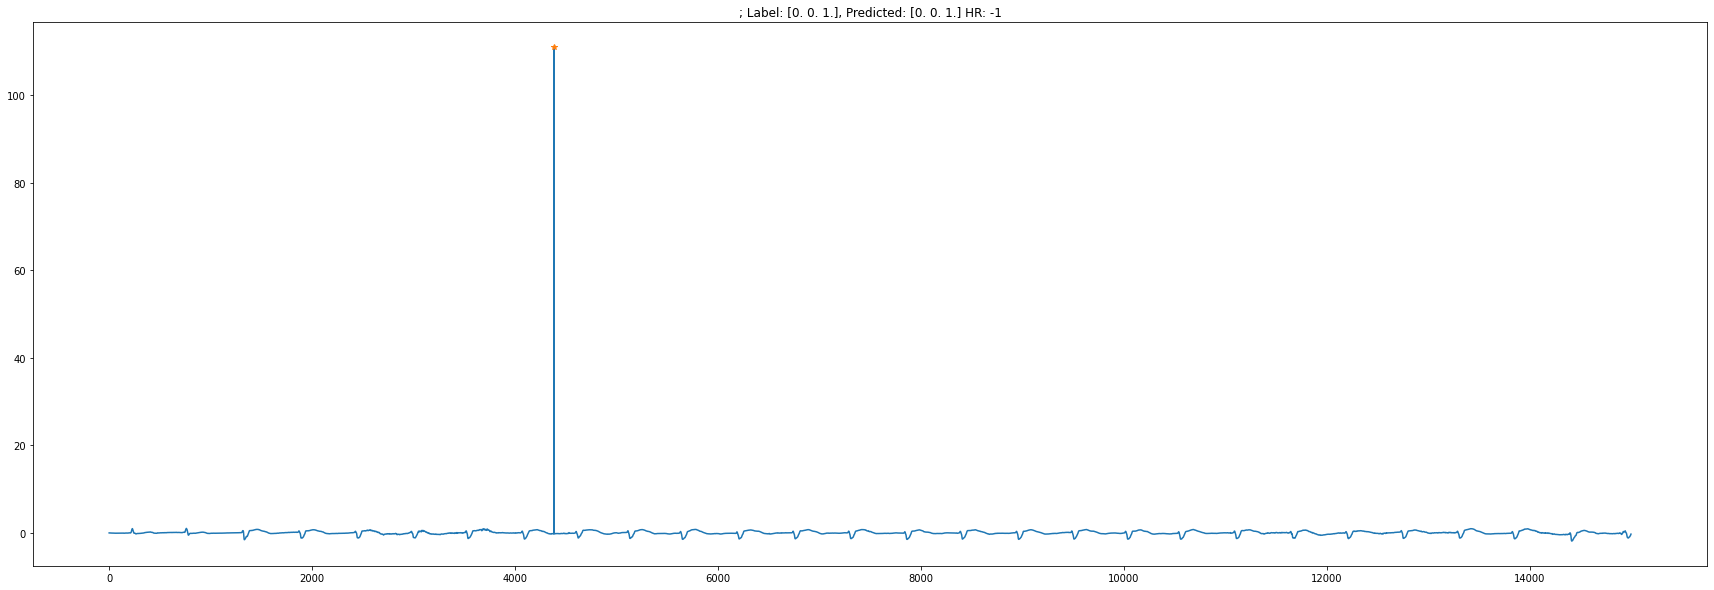

5025542/607


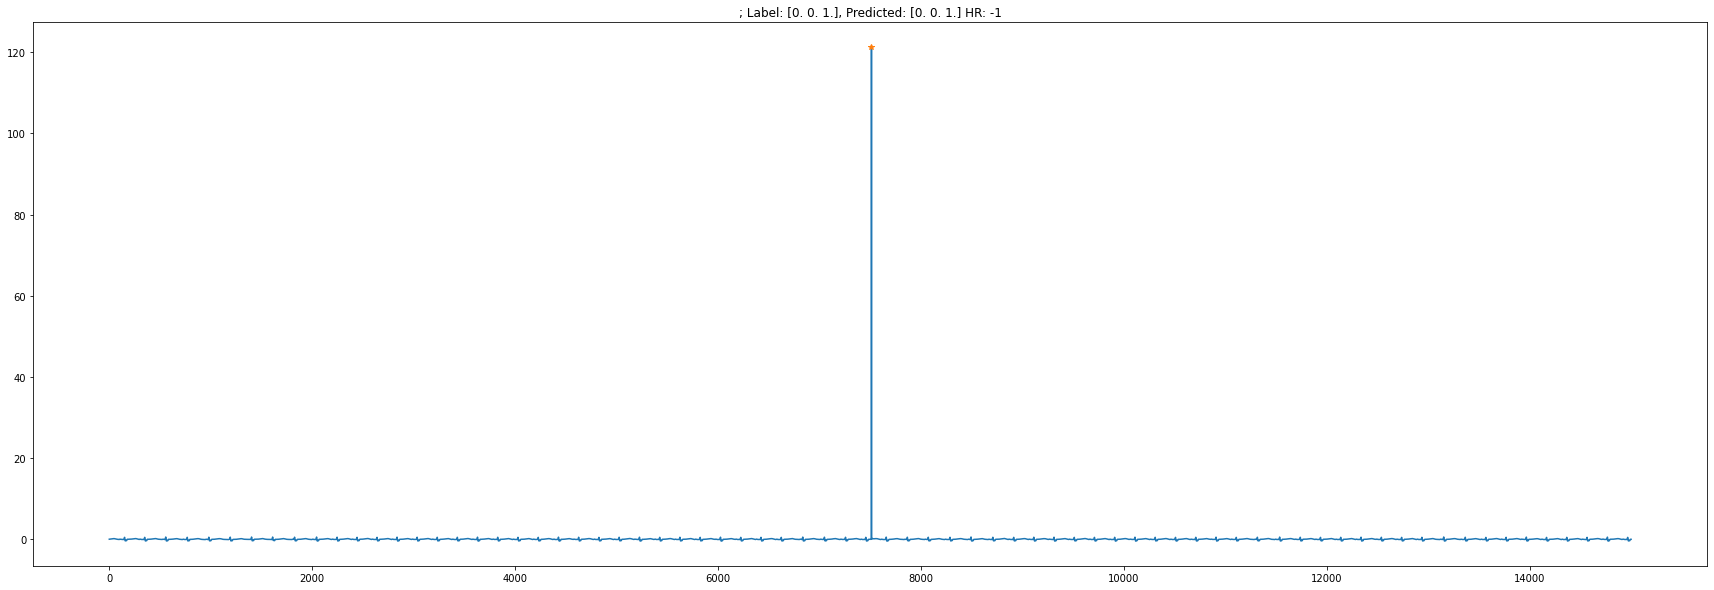

5025547/76


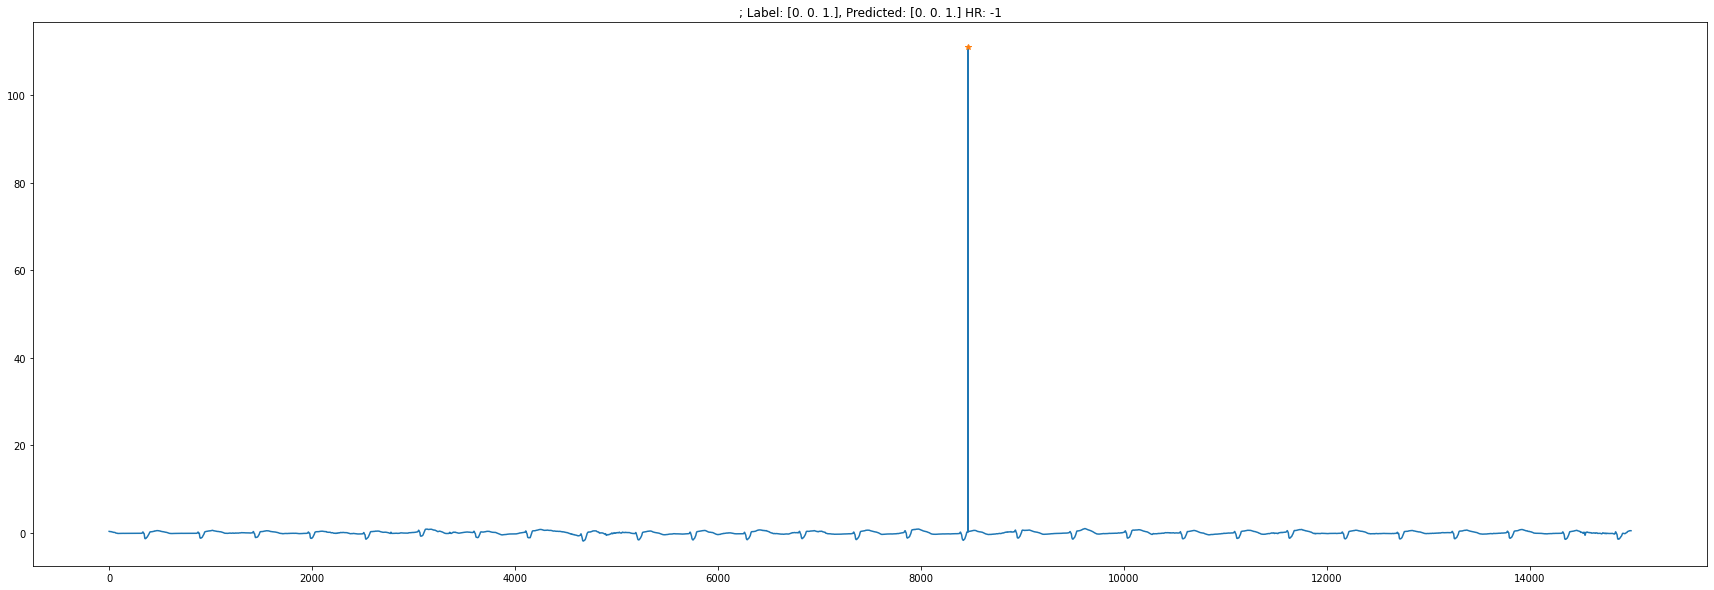

5025542/82


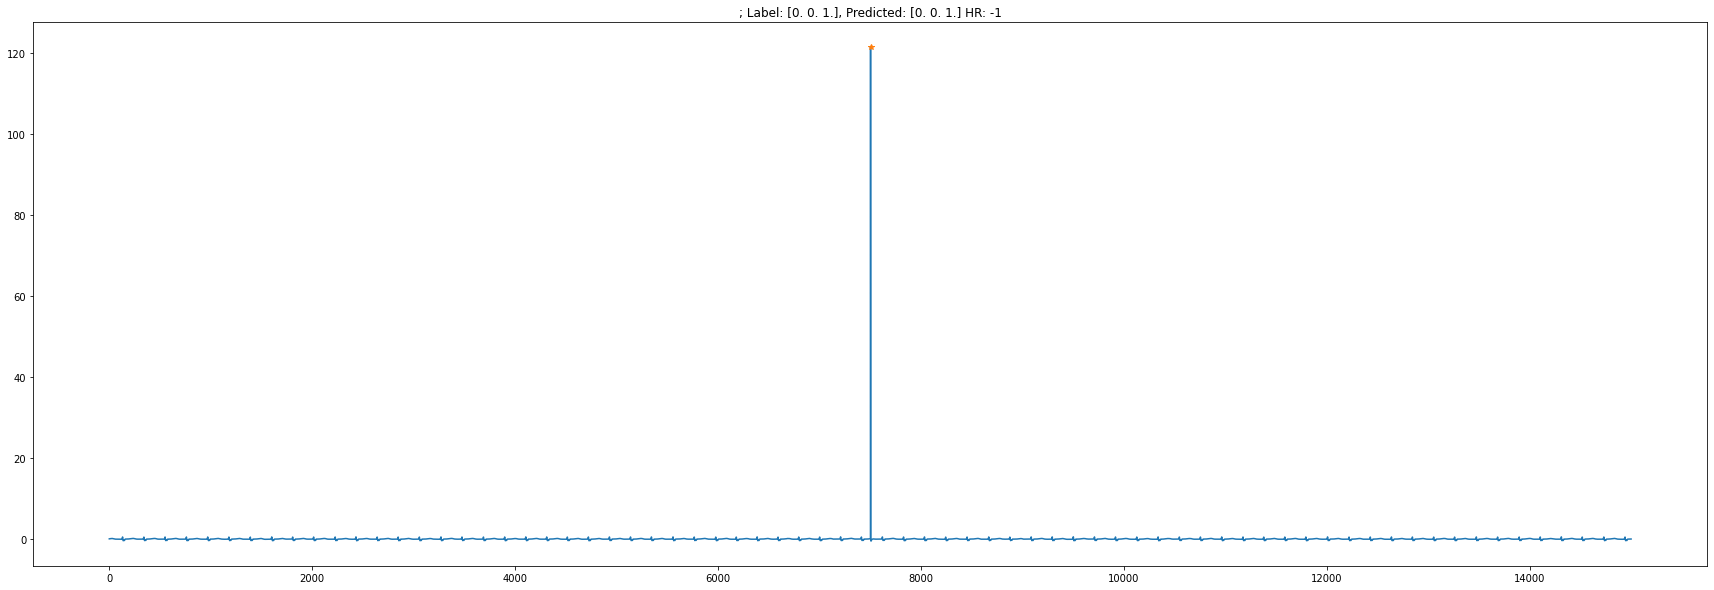

5025547/170


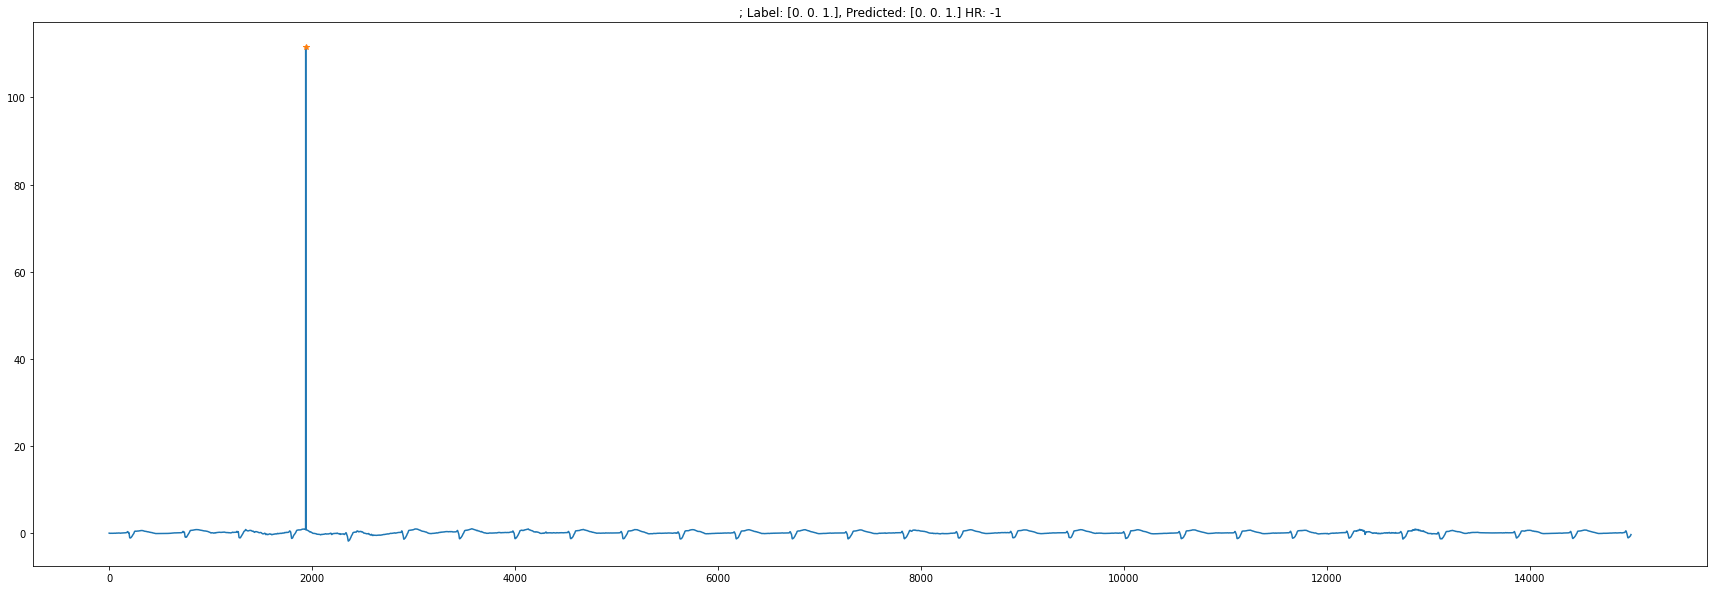

5025547/104


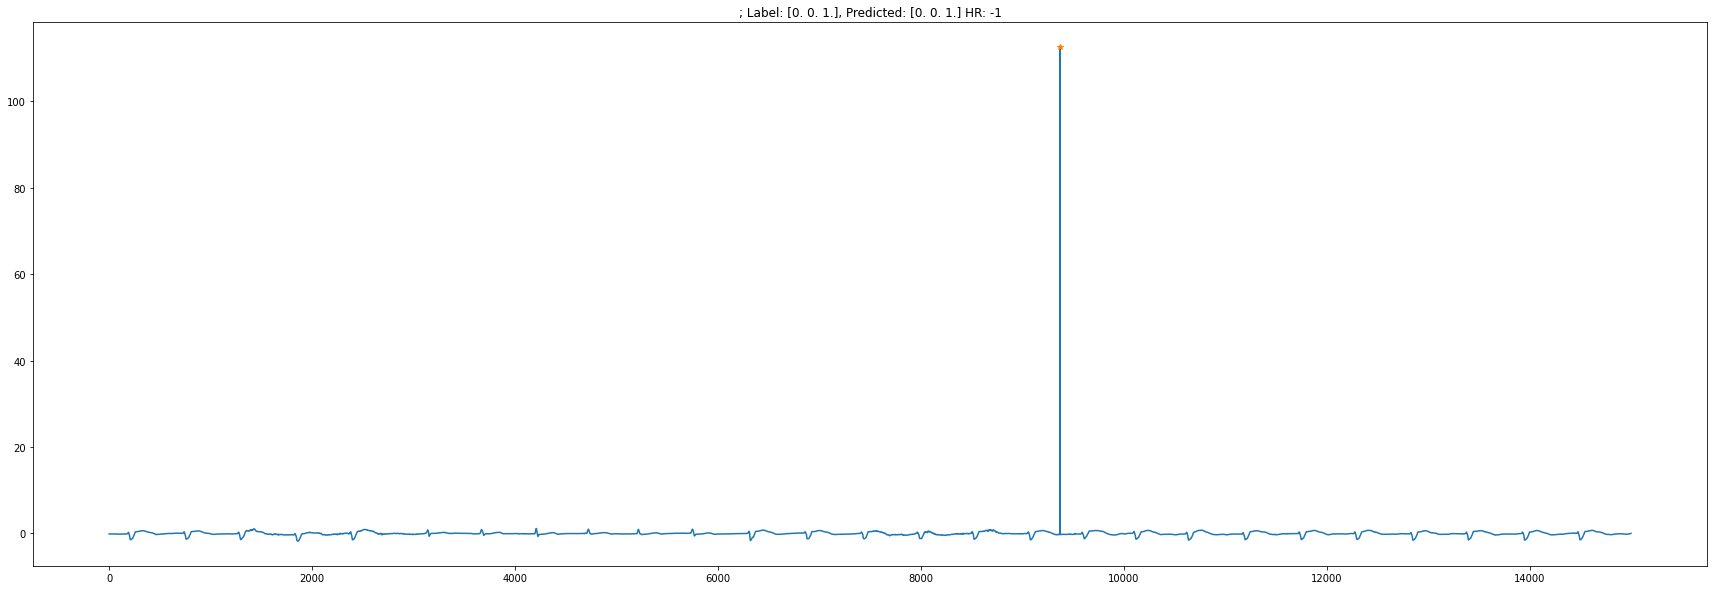

5025547/205


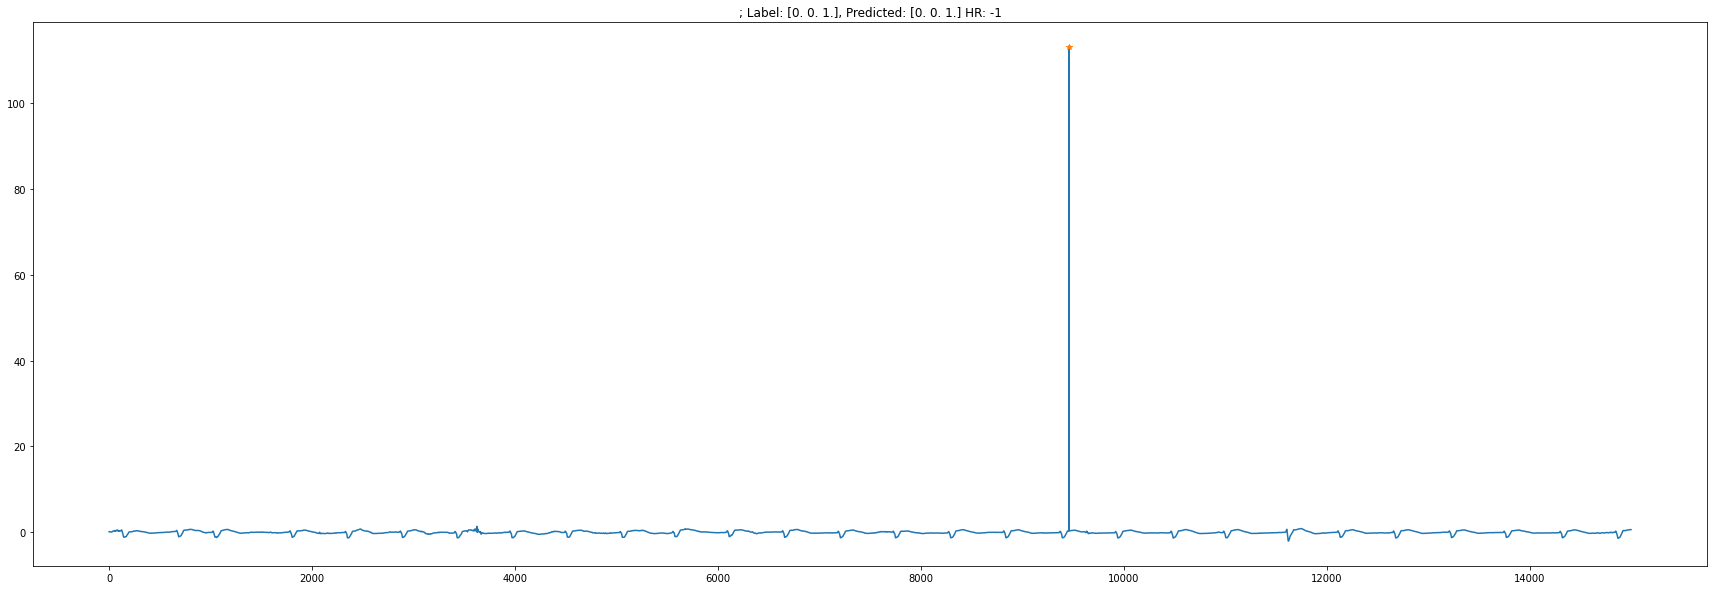

5025547/169


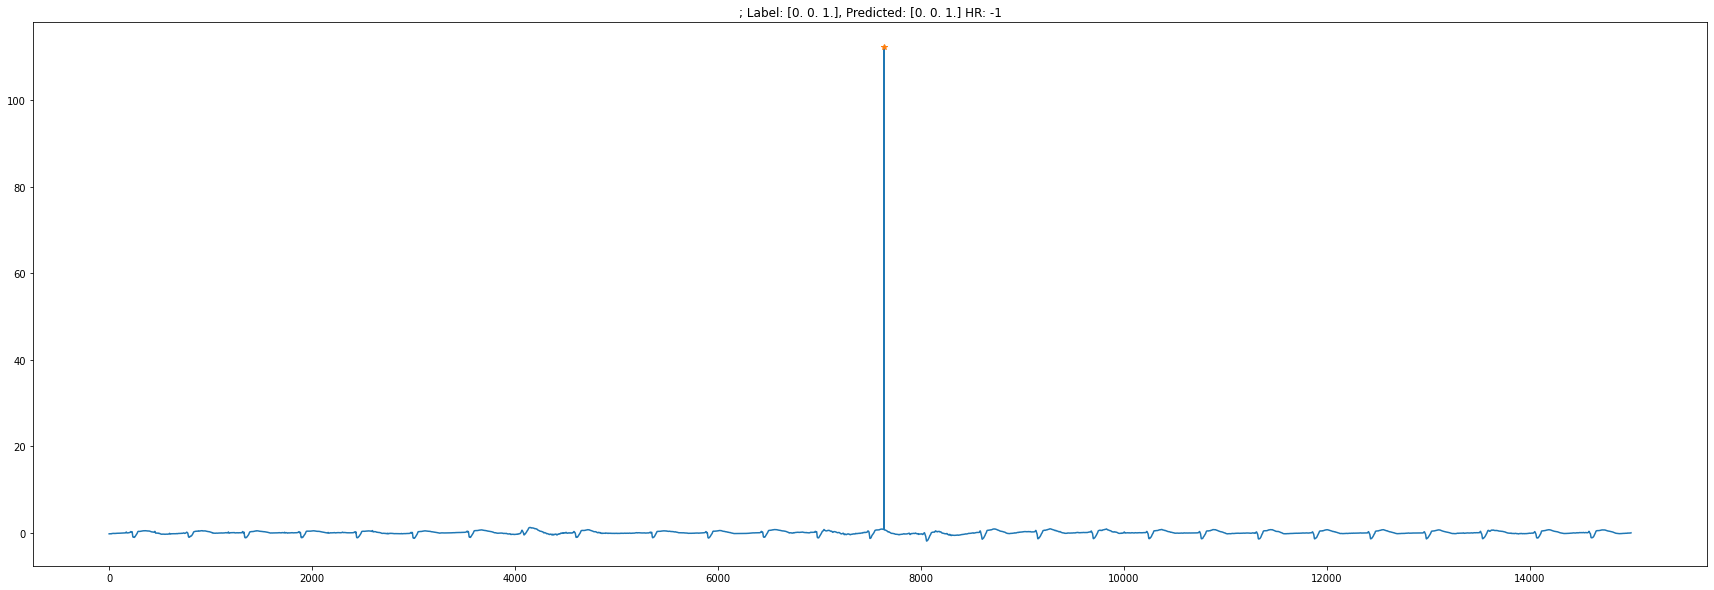

In [53]:
for i in range(N):
    
    #apply preprocessing
    signal = prep.run(signals_best[i],np.array([1]),label_process=False)
    signal = signal.reshape(-1)
    
    #find heart rate
    rr = peak_finder.find_peaks_abp(signal, threshold=4)  #christov_segmenter(signal=signals_worst[i], sampling_rate=125)
    if rr.shape[0]>5:
        HR = np.median(np.diff(rr))
        HR = 60/(HR/500)
    else:
        HR = -1
    
    
    
    fig = plt.figure(figsize=(30,10))
    plt.plot(signal)
    plt.plot(rr,signal[rr],'*')
    plt.title(f'; Label: {labels_best[i,:]}, Predicted: {np.round(preds_best[i,:],2)} HR: {HR}')
    print(records_best[i])
    plt.show()
    